# Working on probabilistic pairwise

In [1]:
import pandas as pd
import re
import sys 
import os
sys.path.insert(0, os.path.abspath("../"))
from pyanp.pairwise import Pairwise
import pyanp.priority as priority
from numpy import log, exp
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [334]:
plt.rcParams["figure.figsize"] = (10,6)

In [335]:
from scipy.stats import triang,truncnorm

In [336]:
?triang

In [337]:
rv = triang(c=0.5, loc=.1, scale=10)

In [338]:
def make_log_triang(lower=1, mid=2, upper=3):
    loc = log(lower)
    scale = log(upper) - log(lower)
    c = (log(mid)-log(lower))/(log(upper)-log(lower))
    return triang(c=c, loc=loc, scale=scale)

In [339]:
tb = make_log_triang(1, 30, 100)

In [340]:
vals = tb.rvs(20)
evals = [exp(v) for v in vals]
display([evals, vals])

[[39.550721157037685,
  2.6935614825289167,
  28.304424243327446,
  24.30909424060482,
  6.910740820092,
  52.869715025100014,
  13.510065153995825,
  9.372316987011208,
  32.63415377221846,
  15.96629713886223,
  7.8512820686678575,
  30.97300435172597,
  5.7015151583578865,
  4.4855945520961695,
  41.47723209556793,
  49.231358587985376,
  18.33192248742198,
  37.865278623681746,
  69.31424868613735,
  14.384057599789566],
 array([3.67758393, 0.99086429, 3.34301813, 3.19085053, 1.93307684,
        3.96783068, 2.60343497, 2.23776034, 3.4853594 , 2.77048007,
        2.06067684, 3.433116  , 1.74073196, 1.50087105, 3.72514465,
        3.89653079, 2.90864394, 3.63403456, 4.23865049, 2.66612048])]

In [341]:
tb.mean()

2.6687891892167492

In [342]:
log(30)

3.4011973816621555

In [343]:
def make_tnorm(myclip_a, myclip_b, my_mean, my_std):
    a, b = (myclip_a - my_mean) / my_std, (myclip_b - my_mean) / my_std
    return truncnorm(a=a, b=b, loc=my_mean, scale=my_std)

def make_tnorm_log(my_mean, my_max):
    delta = log(my_max) - log(my_mean)
    myclip_a = log(my_mean)-delta
    myclip_b = log(my_max)
    return make_tnorm(myclip_a, myclip_b, log(my_mean), 0.5*delta)

In [344]:
tl = make_tnorm(1, 5, 3, 2)

In [345]:
tl.rvs(10)

array([3.72020966, 3.0451699 , 2.26841417, 3.40730278, 1.3966677 ,
       3.00675933, 2.69727153, 4.87776765, 4.9834819 , 3.50225924])

In [346]:
ltl = make_tnorm_log(3, 4.5)

In [347]:
[exp(v) for v in ltl.rvs(10)]

[3.679009214055215,
 3.882277129006833,
 3.6567346885792933,
 2.5300517542673773,
 3.5919560927166274,
 3.318513173423832,
 2.285994509292854,
 2.5615517093657583,
 2.598158204949849,
 2.208518562683808]

## Try another idea

Let's change our vote world from 1/9 - 9 (or -9...,-2, 1,2,3,...9) into something easier to randomly work with.

Let's [-8, 8] and then if value is < 0, multiply by -1, add 1, and then invert.

Otherwise we just add 1.

We call this L-scale (for linear) and M-scale is the standard multiplication.  We need a converter

In [348]:
def ascale_mscale(val):
    if val < 0:
        val = -val
        val += 1
        val = 1.0/val
        return val
    else:
        return val+1
    
def mscale_ascale(val):
    if val == 0:
        return None
    elif val >= 1:
        return val - 1
    else:
        val = 1/val
        val = val-1
        return -val

In [349]:
ascale_mscale(-1)

0.5

In [350]:
class LScaleToMScaleDist:
    def __init__(self, distrib, name):
        self.distrib = distrib
        self.name = name
    
    def rvs(self, size=0):
        rval = self.distrib.rvs(size=size)
        for i in range(len(rval)):
            rval[i] = ascale_mscale(rval[i])
        return rval
    
    def mean(self):
        return lscale_mscale(self.distrib.mean())
    
    def __str__(self):
        return self.name

def plot_sim(rval, alt_names, idealize=False):
    if len(rval.shape) == 1:
        if idealize:
            rval = rval / max(rval)
        df = pd.DataFrame({'alts': alt_names, 'val':rval})
        return  df.plot.bar(x='alts', y='val', rot=0)
    else:
        if idealize:
            rval = (rval.transpose() / rval.max(axis=1)).transpose()
        prisdf = pd.DataFrame(data=rval, columns=alt_names)
        prismean = rval.mean(axis=0)
        #print(prismean)
        meandf = pd.DataFrame({'alts':alt_names, 'val':prismean})
        fig, ax = plt.subplots()
        ax2=ax.twiny()
        ax2.set_xticks([])
        ax.set_xticks([])
        meandf.plot.bar(x='alts', y='val', alpha=0.6, ax=ax)
        #meandf.plot.bar(x='alts', y='val', alpha=0.6)
        prisdf.boxplot(ax=ax2)
        #prisdf.boxplot()
        plt.show()
    
class RPairwiseMatrix:
    def __init__(self, size):
        self.VOTES = [TRI_1, TRI_2,TRI_3, TRI_4, TRI_5, TRI_6, TRI_7, TRI_8, TRI_9]
        self.size = size
        self.matrix = np.empty([size, size], dtype=object)
        for i in range(size):
            self.matrix[i,i] = 1.0
            
    @staticmethod
    def from_lscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    rval.set_lscale(row, col, arr[row, col])
        return rval
    
    @staticmethod
    def from_mscale_nparray(arr):
        size=len(arr)
        rval = RPairwiseMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    if arr[row,col] >= 1:
                        rval.set_lscale(row, col, int(np.round(arr[row, col])-1))
                    else:
                        val = 1/arr[row,col]
                        rval.set_lscale(col, row, int(-(np.round(val)-1)))
        return rval
    
    def set_lscale(self, row, col, val):
        if isinstance(val, (int, np.int, np.int16, np.int32, np.int64)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            data = self.VOTES[val - 1]
            self.matrix[row,col]=data
            self.matrix[col,row] = None
        elif isinstance(val, (float, np.float, np.float16, np.float32, np.float64, np.float128)):
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            self.matrix[row, col] = triang(c=0.5, loc=(val-1.5), scale=3)
            self.matrix[col,row] = None
        else:
            raise Exception("Unknown type "+type(val))
        
    def sim(self, size=1):
        if size > 1:
            # We want a list of these things
            return [self.sim(size=1) for i in range(size)]
        rval = np.identity(self.size)
        for row in range(self.size):
            for col in range(row+1, self.size):
                data = 0
                if self.matrix[row, col] is not None:
                    data = self.matrix[row, col].rvs(size=1)[0]
                    if data >= 0:
                        data = data + 1
                    else:
                        data = 1.0/(-data+1)
                    rval[row, col] = data
                    if data != 0:
                        rval[col, row]=1.0/data
                elif self.matrix[col, row] is not None:
                    data = self.matrix[col, row].rvs(size=1)[0]
                    rval[col, row] = data
                    if data != 0:
                        rval[row, col]=1.0/data
        return rval
    
    def alt_names(self):
        return ['alt '+str(i) for i in range(1, self.size+1)]
    
    def sim_priority(self, size=1):
        mats = self.sim(size)
        if size == 1:
            rval = priority.pri_eigen(mats)
            return rval
        else:
            rval = np.array([priority.pri_eigen(mat) for mat in mats])
            return rval
                
                

        

In [351]:
TRI_1=LScaleToMScaleDist(triang(c=0.5, loc=-1, scale=2), "triangular 1")
TRI_2=LScaleToMScaleDist(triang(c=0.5, loc=-0.25, scale=2.5), "triangular 2")
TRI_3=LScaleToMScaleDist(triang(c=0.5, loc=0.5, scale=3), "triangular 3")
TRI_4=LScaleToMScaleDist(triang(c=0.5, loc=1.5, scale=3), "triangular 4")
TRI_5=LScaleToMScaleDist(triang(c=0.5, loc=2.5, scale=3), "triangular 5")
TRI_6=LScaleToMScaleDist(triang(c=0.5, loc=3.5, scale=3), "triangular 6")
TRI_7=LScaleToMScaleDist(triang(c=0.5, loc=4.5, scale=3), "triangular 7")
TRI_8=LScaleToMScaleDist(triang(c=0.5, loc=5.5, scale=3), "triangular 8")
TRI_9=LScaleToMScaleDist(triang(c=0.5, loc=6.5, scale=3), "triangular 9")

In [352]:
TRI_1.rvs(10)

array([1.44510626, 0.67091036, 1.81535958, 1.45594819, 0.9320103 ,
       0.58299207, 0.85554791, 1.87254428, 0.69373567, 0.72225536])

In [353]:
TRI_2.rvs(10)

array([1.28447839, 2.6007304 , 2.90507383, 2.21664017, 1.65507776,
       1.30847552, 1.40821655, 2.03084268, 1.82599626, 1.77851232])

In [354]:
pw = RPairwiseMatrix(4)

In [355]:
pw.matrix

array([[1.0, None, None, None],
       [None, 1.0, None, None],
       [None, None, 1.0, None],
       [None, None, None, 1.0]], dtype=object)

In [356]:
pw.set_lscale(0,1, 2)
pw.set_lscale(1,2, 3)
pw.set_lscale(2,3, 4)
pw.set_lscale(0, 2, 4)
pw.set_lscale(1, 3, 5)

In [357]:
pw.sim(size=5)

[array([[1.        , 2.79503504, 4.89779364, 0.        ],
        [0.35777727, 1.        , 4.00345762, 5.70824228],
        [0.20417357, 0.24978409, 1.        , 4.18725997],
        [0.        , 0.17518528, 0.23881966, 1.        ]]),
 array([[1.        , 3.41494295, 5.15416869, 0.        ],
        [0.29283066, 1.        , 3.95394643, 5.51742324],
        [0.19401771, 0.25291187, 1.        , 5.76136506],
        [0.        , 0.18124403, 0.17356998, 1.        ]]),
 array([[1.        , 3.62997907, 4.2335175 , 0.        ],
        [0.27548368, 1.        , 4.05127059, 5.77531961],
        [0.2362102 , 0.24683614, 1.        , 4.86684908],
        [0.        , 0.17315059, 0.20547175, 1.        ]]),
 array([[1.        , 2.5396615 , 4.74712904, 0.        ],
        [0.39375326, 1.        , 4.44099105, 7.27227339],
        [0.21065364, 0.22517496, 1.        , 4.65583801],
        [0.        , 0.13750858, 0.2147841 , 1.        ]]),
 array([[1.        , 2.91434066, 5.61851693, 0.        ],
      

In [358]:
m=pw.sim()

In [359]:
display(m)
m.max(axis=0)

array([[1.        , 3.14289931, 4.50200377, 0.        ],
       [0.31817755, 1.        , 4.817158  , 5.56121306],
       [0.22212331, 0.20759128, 1.        , 5.45207335],
       [0.        , 0.17981688, 0.18341646, 1.        ]])

array([1.        , 3.14289931, 4.817158  , 5.56121306])

In [360]:
pw.sim_priority()

array([0.48279228, 0.36642345, 0.11929416, 0.03149011])

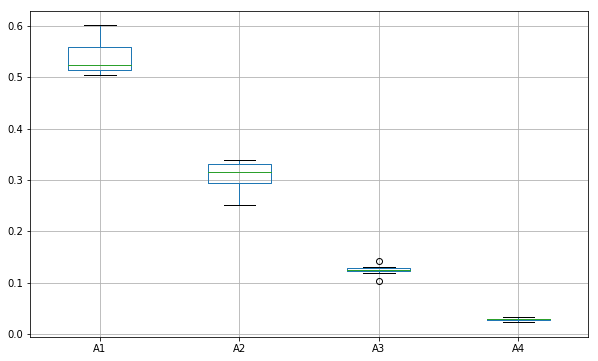

In [361]:
pris = pw.sim_priority(10)
prisdf = pd.DataFrame(data=pris, columns=["A1", "A2", "A3", "A4"])
prisdf.boxplot()

In [362]:
pw.sim_priority(1)

array([0.55847163, 0.29828358, 0.1201798 , 0.02306499])

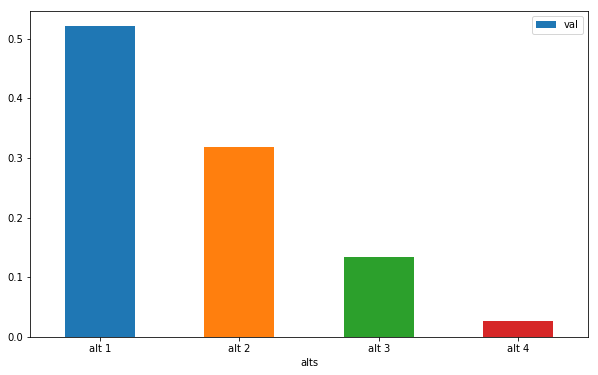

In [363]:
v=pw.sim_priority(1)
plot_sim(v, pw.alt_names())

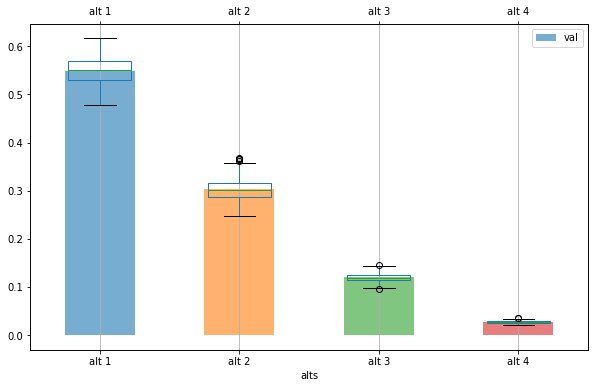

In [364]:
v=pw.sim_priority(size=200)
plot_sim(v, pw.alt_names())

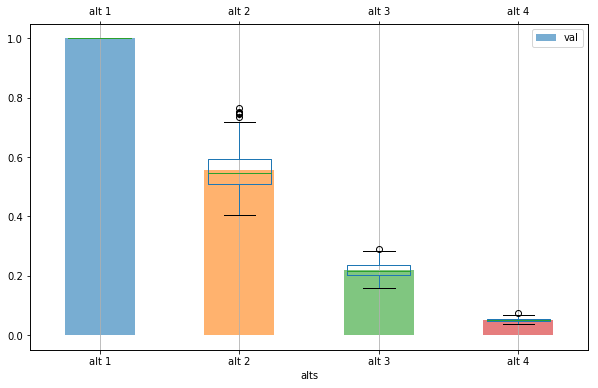

In [365]:
plot_sim(v, pw.alt_names(), idealize=True)

In [366]:
apw = np.array([
    [0, -1, 2],
    [-1., 0, 4],
    [-2, -4., 0]
], dtype=int)
arpw = RPairwiseMatrix.from_lscale_nparray(apw)
arpw.sim_priority(20)

array([[0.3877937 , 0.47488371, 0.13732258],
       [0.41909134, 0.45123762, 0.12967104],
       [0.44568694, 0.44490282, 0.10941024],
       [0.4905813 , 0.39739165, 0.11202705],
       [0.40173575, 0.46232048, 0.13594378],
       [0.34497848, 0.54814877, 0.10687275],
       [0.38913914, 0.48758017, 0.1232807 ],
       [0.42152183, 0.47301944, 0.10545873],
       [0.39543154, 0.47317723, 0.13139122],
       [0.33079407, 0.54779685, 0.12140908],
       [0.34468245, 0.54196846, 0.11334909],
       [0.4332779 , 0.46031938, 0.10640271],
       [0.43739745, 0.44543372, 0.11716882],
       [0.44171176, 0.43558546, 0.12270278],
       [0.32308963, 0.53633179, 0.14057858],
       [0.36705842, 0.51639944, 0.11654214],
       [0.39424054, 0.48204137, 0.12371809],
       [0.42599027, 0.45662754, 0.11738219],
       [0.3184981 , 0.57473792, 0.10676398],
       [0.46800781, 0.41512313, 0.11686906]])

In [367]:
mpw = np.array([
    [1, 2, 3],
    [1/2, 1, 5],
    [1/3, 1/5, 1]
])
mrpw = RPairwiseMatrix.from_mscale_nparray(mpw)

In [368]:
mrpw.sim()

array([[1.        , 2.23353078, 3.44749215],
       [0.44772161, 1.        , 5.36430265],
       [0.29006593, 0.18641752, 1.        ]])

In [369]:
mrpw.sim_priority(20)

array([[0.53125667, 0.36879107, 0.09995226],
       [0.44705906, 0.44131146, 0.11162948],
       [0.48796163, 0.38866168, 0.12337669],
       [0.47004243, 0.40138575, 0.12857182],
       [0.55015411, 0.33983347, 0.11001242],
       [0.53987557, 0.33998258, 0.12014186],
       [0.49999967, 0.3849579 , 0.11504243],
       [0.49197965, 0.41295417, 0.09506619],
       [0.50217205, 0.36975502, 0.12807293],
       [0.47731506, 0.4100473 , 0.11263764],
       [0.4807085 , 0.39875432, 0.12053718],
       [0.45430379, 0.40643695, 0.13925926],
       [0.48090958, 0.41412979, 0.10496063],
       [0.51590265, 0.34742812, 0.13666923],
       [0.49033187, 0.38054494, 0.12912319],
       [0.51592001, 0.38117452, 0.10290546],
       [0.49992086, 0.38167872, 0.11840042],
       [0.49575333, 0.38298241, 0.12126426],
       [0.50287129, 0.3887302 , 0.10839852],
       [0.51221446, 0.37989353, 0.10789201]])

# Another idea
Here we have the pariwise comparison matrix class storing everything in LinearScale and only converting to ExponentialScale when we do the simulation

In [370]:
class RandLScalePwMatrix:
    VOTES = [
        triang(c=0.5, loc=-1, scale=2), #Triangle about 0
        triang(c=0.5, loc=-0.25, scale=2.5), #Triangle about 1
        triang(c=0.5, loc=0.5, scale=3), #Triangle about 2
        triang(c=0.5, loc=1.5, scale=3), #Triangle about 3
        triang(c=0.5, loc=2.5, scale=3), #Triangle about 4
        triang(c=0.5, loc=3.5, scale=3), #Triangle about 5
        triang(c=0.5, loc=4.5, scale=3), #Triangle about 6
        triang(c=0.5, loc=5.5, scale=3), #Triangle about 7
        triang(c=0.5, loc=6.5, scale=3), #Triangle about 8
        triang(c=0.5, loc=7.5, scale=3), #Triangle about 9
    ]
    
    def __init__(self, size):
        self.size = size
        self.matrix = np.empty([size, size], dtype=object)
        for i in range(size):
            self.matrix[i,i] = 1.0
            
    @staticmethod
    def from_nparray(arr):
        size=len(arr)
        rval = RandLScalePwMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row,col] != 0:
                    rval.set(row, col, arr[row, col])
        return rval
    
    @staticmethod
    def from_mscale_nparray(arr):
        size=len(arr)
        rval = RandLScalePwMatrix(size)
        for row in range(size):
            for col in range(row+1, size):
                if arr[row, col]!=0:
                    rval.setm(row, col, arr[row, col])
        return rval
    
    def setm(self, row, col, multiplicative_value):
        val = mscale_ascale(multiplicative_value)
        print("mval="+str(multiplicative_value)+" addval="+str(val))
        self.set(row, col, val)
        
    def set(self, row, col, val):
        rnd_val = int(np.round(val))
        if (np.abs(rnd_val - val) < 1e-10):
            #We have essentially an integer vote
            if val < 0:
                tmp = row
                row = col
                col = tmp
                rnd_val = -rnd_val
            data = RandLScalePwMatrix.VOTES[rnd_val]
            self.matrix[row,col]=data
            self.matrix[col,row] = None
        else:
            #Floating point vote
            if val < 0:
                tmp = row
                row = col
                col = tmp
                val = -val
            self.matrix[row, col] = triang(c=0.5, loc=(val-1.5), scale=3)
            self.matrix[col,row] = None
        
    def sim(self, size=1):
        if size > 1:
            # We want a list of these things
            return [self.sim(size=1) for i in range(size)]
        rval = np.identity(self.size)
        for row in range(self.size):
            for col in range(row+1, self.size):
                data = 0
                if self.matrix[row, col] is not None:
                    data = self.matrix[row, col].rvs(size=1)[0]
                    data = ascale_mscale(data)
                    rval[row, col] = data
                    if data != 0:
                        rval[col, row]=1.0/data
                elif self.matrix[col, row] is not None:
                    data = self.matrix[col, row].rvs(size=1)[0]
                    data = ascale_mscale(data)
                    rval[col, row] = data
                    if data != 0:
                        rval[row, col]=1.0/data
        return rval
    
    def alt_names(self):
        return ['alt '+str(i) for i in range(1, self.size+1)]
    
    def sim_priority(self, size=1):
        mats = self.sim(size)
        if size == 1:
            rval = priority.pri_eigen(mats)
            return rval
        else:
            rval = np.array([priority.pri_eigen(mat) for mat in mats])
            return rval
                

In [371]:
rmls = RandLScalePwMatrix(3)

In [372]:
rmls.set(0,1, 1)
rmls.set(1,2, 2)
rmls.set(0,2, 3)

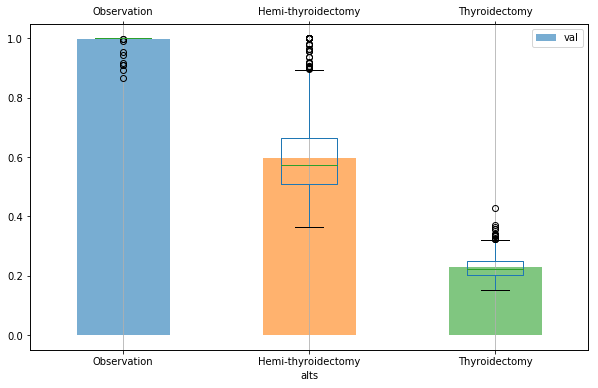

In [373]:
pris = rmls.sim_priority(1000)
plot_sim(pris, ['Observation', 'Hemi-thyroidectomy', 'Thyroidectomy'], idealize=True)

In [374]:
r2 = RandLScalePwMatrix.from_mscale_nparray(np.array([
    [1, 2, 1/3.],
    [1/2, 1, 3],
    [3, 1/3, 1]
]))

mval=2.0 addval=1.0
mval=0.3333333333333333 addval=-2.0
mval=3.0 addval=2.0


[0.7412372  0.9753208  0.85076374]


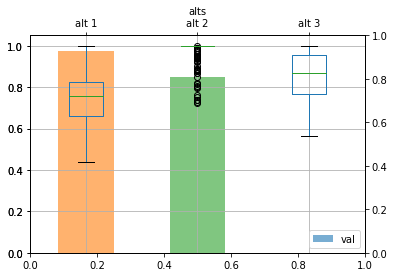

In [42]:
plot_sim(r2.sim_priority(200), r2.alt_names(), idealize=True)

In [43]:
r2.matrix[2,0].median()

2.0

In [44]:
r2.matrix

array([[1.0,
        None],
       [None, 1.0,
        None, 1.0]], dtype=object)

In [45]:
'''
Group pairwise object and calculations.  See :py:mod:`pyanp.priority` for
all methods of calculating priorities from a pairwise comparison matrix
in addition to inconsistency calculations.
'''

import numpy as np
import pandas as pd
from pyanp.priority import incon_std
from pyanp.general import islist, matrix_as_df
from pyanp.prioritizer import Prioritizer, PriorityType
from pyanp.priority import pri_eigen
from copy import deepcopy
import re

